# Step 1: Requirements and Packaide Setup

In [1]:
# Update package lists quietly
!sudo apt-get update -qq

# Install CMake (version 3.13+)
!sudo apt-get install -y cmake

# Install Boost libraries (including Boost.Python)
!sudo apt-get install -y libboost-all-dev

# Install CGAL and its dependencies
!sudo apt-get install -y libcgal-dev

# Install other essential build tools
!sudo apt-get install -y build-essential git

# Install Python development headers (required for building Python bindings)
!sudo apt-get install -y python3-dev

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libboost-all-dev is already the newest version (1.74.0.3ubuntu7).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgmp-dev libgmpxx4ldbl libmpfr-dev
Suggested packages:
  libmpfi-dev libntl-dev gmp-doc libgmp10-doc libmpfr-doc
The following NEW packages will be installed:
  libcgal-dev libgmp-dev libgmpxx4ldbl libmpfr-

In [2]:
# Packages mainly related to unfolding
%%shell
pip install "drawsvg==2.3.0" &&\
pip install "libigl==2.4.1" &&\
pip install git+https://github.com/skoch9/meshplot.git@v0.4.0 pythreejs==2.4.1 &&\
apt update &&\
apt install cairosvg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 10.6 MB/s eta 0:00:00
  Cloning https://github.com/skoch9/meshplot.git (to revision v0.4.0) to /tmp/pip-req-build-09zvfh7z
  Running command git clone --filter=blob:none --quiet https://github.com/skoch9/meshplot.git /tmp/pip-req-build-09zvfh7z
  Running command git checkout -q 4708aa93018fa3ee547d0a9a091ac34f1e2ecb64
  Resolved https://github.com/skoch9/meshplot.git to commit 4708aa93018fa3ee547d0a9a091ac34f1e2ecb64
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.7/271.7 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.9 MB/s eta 0:00:00
  Created wheel for meshplot: filename=meshplot-0.3.3-py3-none-any.whl size=21119 sha256=191dcecf9460b7f6ace2ac4a96844b9a5fb339748005e6e0b586c94752ef1490
  Stored in di

In [3]:
# Install remaining Python packages
!pip install shapely svgwrite parameterized svgelements

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 8.7 MB/s eta 0:00:00


In [4]:
# Clone the Packaide repository
!git clone https://github.com/DanielLiamAnderson/Packaide.git

Cloning into 'Packaide'...
remote: Enumerating objects: 583, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 583 (delta 51), reused 86 (delta 29), pack-reused 466 (from 1)
Receiving objects: 100% (583/583), 300.82 KiB | 6.84 MiB/s, done.
Resolving deltas: 100% (263/263), done.


In [5]:
# Create a build directory and navigate into it
# always come back to the parent dir if you don't want a problem
%cd /content/Packaide
!mkdir build
%cd build

# Configure the build with CMake
!cmake -DBUILD_PYTHON_BINDINGS=ON ..

# Compile the library using all available CPU cores
!make -j$(nproc)
!make check
!sudo make install

%cd /content/Packaide/python
!pip install .

/content/Packaide
/content/Packaide/build
-- The CXX compiler identification is GNU 11.4.0
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- --------------- General configuration -------------
-- CMake Generator:                Unix Makefiles
-- Compiler:                       GNU 11.4.0
-- Build type:                     Release
-- CMAKE_CXX_FLAGS:                
-- CMAKE_CXX_FLAGS_DEBUG:          -g
-- CMAKE_CXX_FLAGS_RELEASE:        -O3 -DNDEBUG
-- CMAKE_CXX_FLAGS_RELWITHDEBINFO: -O2 -g -DNDEBUG -fno-omit-frame-pointer
-- CMAKE_EXE_LINKER_FLAGS          
-- CMAKE_INSTALL_PREFIX:           /usr/local
-- ---------------------------------------------------
CMake Warning at /usr/lib/x86_64-linux-gnu/cmake/CGAL/CGALConfig.cmake:92 (message):
  CGAL_DATA_DIR cannot be deduced, set the variable CGAL_DATA_DIR to set the
  default

##Test packaide Setup

In [7]:
import packaide
print("Packaide imported successfully!")

Packaide imported successfully!


###We you could test if its working fine using this example usage from packaide readme documentation

In [9]:
# Shapes are provided in SVG format
shapes = """
<svg viewBox="0 0 432.13 593.04">
  <rect width="100" height="50" />
  <rect width="50" height="100" />
  <ellipse rx="20" ry="20" />
</svg>
"""

# The target sheet / material is also represented as an SVG
# document. Shapes given on the sheet are interpreted as
# holes that must be avoided when placing new parts. In this
# case, a square in the upper-left-hand corner.
sheet = """
<svg width="300" height="300" viewBox="0 0 300 300">
  <rect x="0" y="0" width="100" height="100" />
</svg>
"""

# Attempts to pack as many of the parts as possible.
result, placed, fails = packaide.pack(
  [sheet],                  # A list of sheets (SVG documents)
  shapes,                   # An SVG document containing the parts
  tolerance = 2.5,          # Discretization tolerance
  offset = 5,               # The offset distance around each shape (dilation)
  partial_solution = True,  # Whether to return a partial solution
  rotations = 1,            # The number of rotations of parts to try
  persist = True            # Cache results to speed up next run
)

# If partial_solution was False, then either every part is placed or none
# are. Otherwise, as many as possible are placed. placed and fails denote
# the number of parts that could be and could not be placed respectively
print("{} parts were placed. {} parts could not fit on the sheets".format(placed, fails))

# The results are given by a list of pairs (i, out), where
# i is the index of the sheet on which shapes were packed, and
# out is an SVG representation of the parts that are to be
# placed on that sheet.
for i, out in result:
  with open('result_sheet_{}.svg'.format(i), 'w') as f_out:
    f_out.write(out)

3 parts were placed. 0 parts could not fit on the sheets


# Step 2: Unfolding

> The next step is, given an stl file of a 3d convex shape, unfold it into all the valid unique nets and ready it for computation in the next part of the pipeline.

### this one does pretty good job for a cube

Total spanning trees found: 384
Non-overlapping nets found: 30
Distinct nets (up to congruence): 30


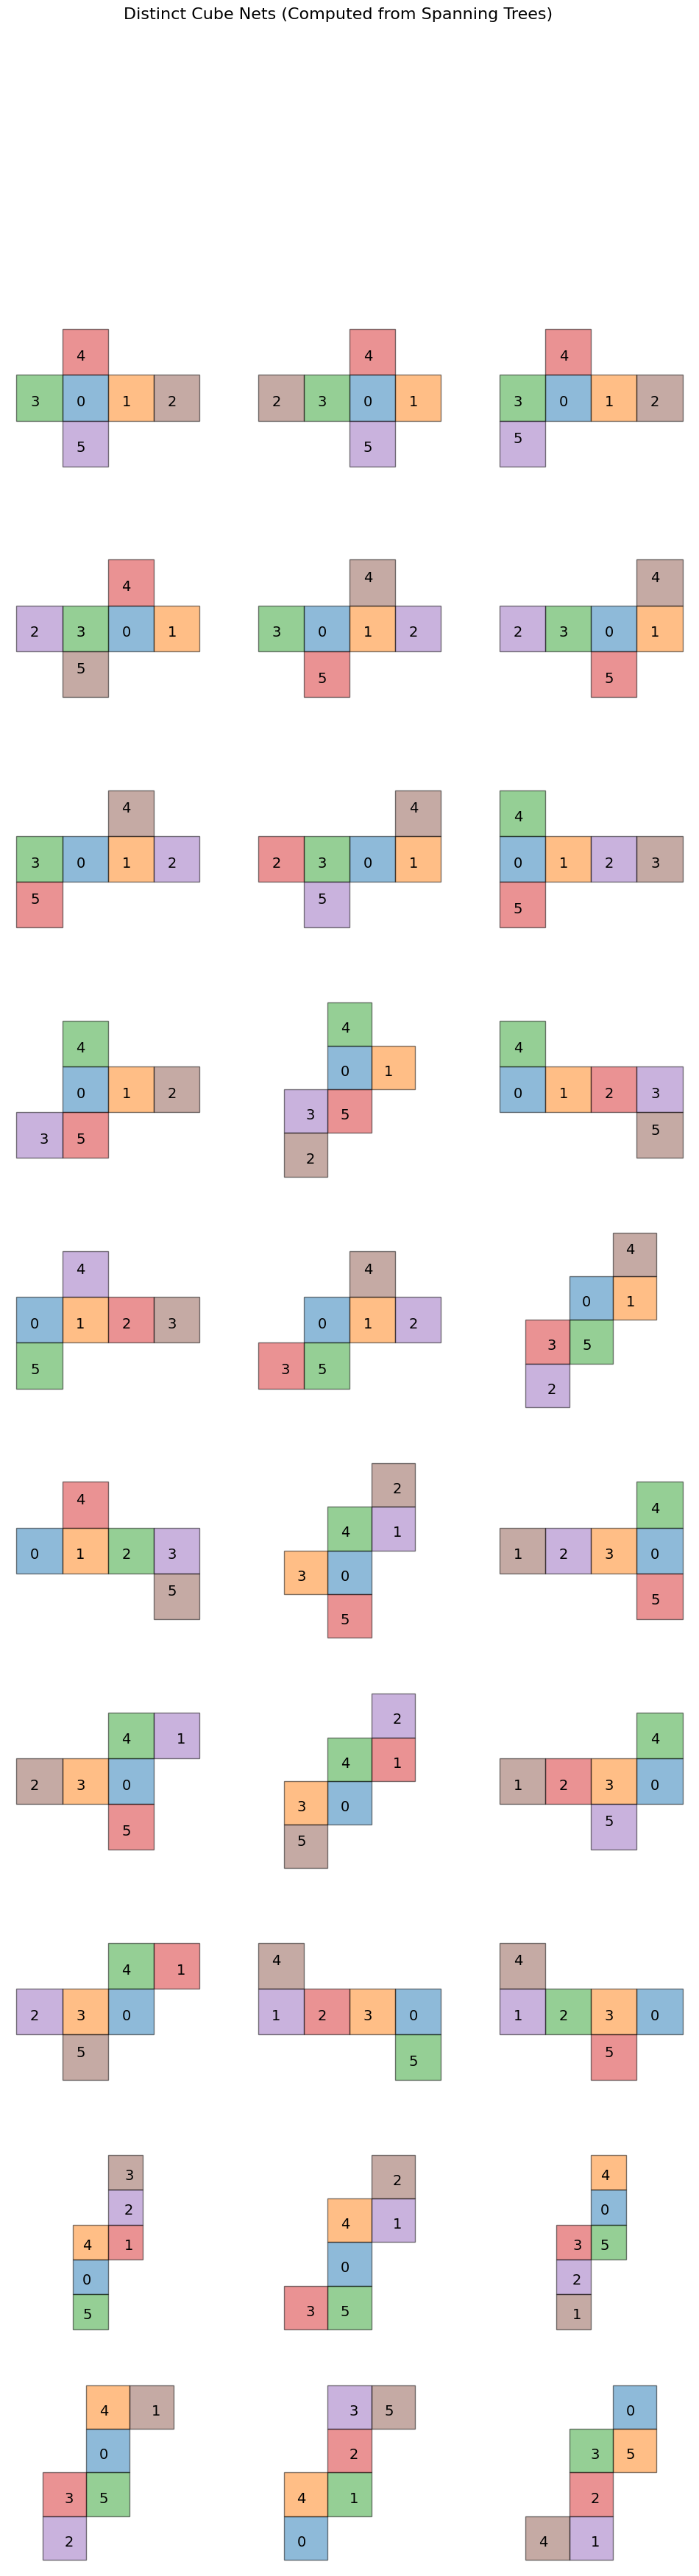

In [37]:
#%% [code]
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import Polygon
import itertools

# --- Helper functions for 2D affine transformations ---
def rotation_matrix(theta):
    return np.array([[np.cos(theta), -np.sin(theta)],
                     [np.sin(theta),  np.cos(theta)]])

def to_homogeneous(p):
    return np.array([p[0], p[1], 1.0])

def transform_point(T, p):
    return (T @ to_homogeneous(p))[:2]

# Canonical unit square: (lower-left, lower-right, upper-right, upper-left)
square = np.array([[0,0], [1,0], [1,1], [0,1]])

# For the canonical square, let's define an anchor point and a direction vector for each edge.
# Conventions:
edge_params = {
    'bottom': (np.array([0,0]), np.array([1,0])),
    'right':  (np.array([1,0]), np.array([0,1])),
    'top':    (np.array([0,1]), np.array([1,0])),
    'left':   (np.array([0,0]), np.array([0,1]))
}

def attach_square(base_T, base_edge, new_edge):
    """
    Given a base face (with transform base_T) and an attachment specified
    by aligning the base_edge of the base face with the new_edge of the new face,
    compute the new face's transform. We assume a rotation of ±90° so that the two squares lie flat.
    """
    # Get the anchor and direction for the base edge in canonical coordinates.
    p_base_c, d_base_c = edge_params[base_edge]
    # Transform the anchor and direction into world coordinates.
    p_base = transform_point(base_T, p_base_c)
    R_base = base_T[:2, :2]
    d_base = R_base @ d_base_c
    d_base = d_base / np.linalg.norm(d_base)

    # For the new face, get its canonical anchor and direction.
    p_new_c, d_new_c = edge_params[new_edge]
    d_new = d_new_c / np.linalg.norm(d_new_c)

    # Compute the angle required to rotate d_new to align with d_base.
    angle = np.arctan2(d_base[1], d_base[0]) - np.arctan2(d_new[1], d_new[0])
    R_new = rotation_matrix(angle)

    # Compute translation so that the new face's attaching edge aligns with the base edge.
    t_new = p_base - (R_new @ p_new_c)

    T_new = np.eye(3)
    T_new[:2, :2] = R_new
    T_new[:2, 2] = t_new
    return T_new

# --- Define the cube's face connectivity and hinge rules ---
# Labeling faces: 0: front, 1: right, 2: back, 3: left, 4: top, 5: bottom.
# For each directed adjacent pair (i,j), we also specify (edge_i, edge_j).
hinge = {
    (0,1): ('right', 'left'),
    (0,3): ('left', 'right'),
    (0,4): ('top', 'bottom'),
    (0,5): ('bottom', 'top'),
    (1,2): ('right', 'left'),
    (1,4): ('top', 'right'),
    (1,5): ('bottom', 'right'),
    (3,2): ('left', 'right'),
    (3,4): ('top', 'left'),
    (3,5): ('bottom', 'left'),
    (2,4): ('top', 'top'),
    (2,5): ('bottom', 'bottom')
}
# Add symmetric entries.
hinge.update({(j,i):(hinge[(i,j)][1], hinge[(i,j)][0]) for (i,j) in list(hinge.keys())})

# Define the undirected connectivity of the cube's faces.
faces = [0,1,2,3,4,5]
edges = [(0,1), (0,3), (0,4), (0,5),
         (1,2), (1,4), (1,5),
         (2,3), (2,4), (2,5),
         (3,4), (3,5)]
G = nx.Graph()
G.add_nodes_from(faces)
G.add_edges_from(edges)

# --- Brute-force enumeration of spanning trees ---
def all_spanning_trees(G):
    n = G.number_of_nodes()
    trees = []
    for subset in itertools.combinations(G.edges(), n-1):
        H = nx.Graph()
        H.add_nodes_from(G.nodes())
        H.add_edges_from(subset)
        if nx.is_tree(H):
            trees.append(H)
    return trees

all_trees = all_spanning_trees(G)
print("Total spanning trees found:", len(all_trees))

# --- Compute a net given a spanning tree ---
def compute_net(tree):
    transforms = {0: np.eye(3)}  # Fix face 0 with identity transform.
    stack = [0]
    parent = {0: None}
    while stack:
        curr = stack.pop()
        for nbr in tree.neighbors(curr):
            if nbr not in transforms:
                if (curr, nbr) in hinge:
                    base_edge, new_edge = hinge[(curr, nbr)]
                else:
                    continue
                transforms[nbr] = attach_square(transforms[curr], base_edge, new_edge)
                parent[nbr] = curr
                stack.append(nbr)
    return transforms

# Compute 2D polygons for each face given its transform.
def net_polygons(transforms):
    polys = {}
    for f, T in transforms.items():
        pts = np.array([transform_point(T, p) for p in square])
        polys[f] = Polygon(pts)
    return polys

# Normalize net layout: translate so that minimum x,y is 0.
def normalize_net(polys):
    all_coords = np.concatenate([np.array(poly.exterior.coords) for poly in polys.values()])
    min_xy = all_coords.min(axis=0)
    norm_polys = {}
    for f, poly in polys.items():
        norm_coords = [(x - min_xy[0], y - min_xy[1]) for x, y in poly.exterior.coords]
        norm_polys[f] = Polygon(norm_coords)
    return norm_polys

# Check for overlaps (ignoring touching boundaries).
def net_overlaps(norm_polys):
    poly_list = list(norm_polys.values())
    for poly1, poly2 in itertools.combinations(poly_list, 2):
        if poly1.intersects(poly2):
            inter = poly1.intersection(poly2)
            if inter.area > 1e-6:
                return True
    return False

# Collect non-overlapping nets.
nets = []
net_transforms = []  # For potential further use.

for tree in all_trees:
    transforms = compute_net(tree)
    polys = net_polygons(transforms)
    norm_polys = normalize_net(polys)
    if not net_overlaps(norm_polys):
        nets.append(norm_polys)
        net_transforms.append(transforms)

print("Non-overlapping nets found:", len(nets))

# Remove duplicates up to congruence using a heuristic key based on coordinates.
def net_key(norm_polys):
    key_parts = []
    for f in sorted(norm_polys.keys()):
        coords = np.array(norm_polys[f].exterior.coords)
        key_parts.append(tuple(np.round(coords, 3).flatten()))
    return tuple(key_parts)

unique_keys = {}
unique_nets = []
for norm_polys in nets:
    key = net_key(norm_polys)
    if key not in unique_keys:
        unique_keys[key] = True
        unique_nets.append(norm_polys)

print("Distinct nets (up to congruence):", len(unique_nets))

# Plot the distinct nets.
n_plots = len(unique_nets)
cols = 3
rows = int(np.ceil(n_plots / cols))
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
axes = axes.flatten()

for ax, net_poly in zip(axes, unique_nets):
    for f, poly in net_poly.items():
        x, y = poly.exterior.xy
        ax.fill(x, y, alpha=0.5, edgecolor='k')
        ax.text(np.mean(x), np.mean(y), str(f), ha='center', va='center', fontsize=14)
    ax.set_aspect('equal')
    ax.axis('off')

for ax in axes[len(unique_nets):]:
    ax.axis('off')

plt.suptitle("Distinct Cube Nets (Computed from Spanning Trees)", fontsize=16)
plt.show()
#%% [code]


### Unfolding script (input: stl image) and (expected output: display valid connected triangles as faces / candidate nets)
> This script isn't complete in a way that its not giving us what we expected

In [82]:
#%% [code]
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import Polygon
import itertools
import igl
import ipywidgets as widgets
from IPython.display import display, HTML
import tempfile, os
from scipy.spatial import ConvexHull
import drawsvg as draw

# Part 1. Mesh Preprocessing and Face Grouping (for convex meshes from STL)
def merge_vertices(V, decimals=5):
    """Merge duplicate vertices using rounding."""
    V_rounded = np.round(V, decimals=decimals)
    unique_V, inv = np.unique(V_rounded, axis=0, return_inverse=True)
    return unique_V, inv

def face_basis(face):
    """
    Given a face (at least 3 noncollinear vertices), return (p0, x_axis, y_axis, n)
    where p0 is the first vertex, x_axis is along (p1-p0), y_axis is perpendicular in the plane,
    and n is the unit normal.
    """
    p0, p1, p2 = face[:3]
    v1 = p1 - p0
    v2 = p2 - p0
    x_axis = v1 / np.linalg.norm(v1)
    n = np.cross(v1, v2)
    n = n / np.linalg.norm(n)
    y_axis = np.cross(n, x_axis)
    return p0, x_axis, y_axis, n

def base_transform(face):
    """
    Return a transformation T: R^3 -> R^2 for a given face.
    Uses the face basis computed from the first three vertices.
    """
    p0, x_axis, y_axis, _ = face_basis(face)
    def T(p):
        v = p - p0
        return np.array([np.dot(v, x_axis), np.dot(v, y_axis)])
    return T

def group_triangles(V, F, normal_thresh=0.99):
    """
    Group adjacent triangles that are nearly coplanar into a full face.
    For each connected component (of triangles sharing an edge with similar normals),
    compute the convex hull (in the plane) to yield a polygon.
    """
    m = F.shape[0]
    normals = np.zeros((m, 3))
    for i in range(m):
        # Ensure F[i] is an array of indices.
        face_indices = F[i] if hasattr(F[i], '__iter__') else np.array([F[i]])
        if face_indices.shape[0] < 3:
            continue  # Skip invalid faces.
        face = V[face_indices]
        _, _, _, n = face_basis(face)
        normals[i] = n
    G_tri = nx.Graph()
    G_tri.add_nodes_from(range(m))
    for i in range(m):
        face_indices_i = F[i] if hasattr(F[i], '__iter__') else np.array([F[i]])
        set_i = set(face_indices_i)
        for j in range(i+1, m):
            face_indices_j = F[j] if hasattr(F[j], '__iter__') else np.array([F[j]])
            set_j = set(face_indices_j)
            if len(set_i.intersection(set_j)) == 2:
                # Use absolute value to allow grouping even if normals are reversed.
                if abs(np.dot(normals[i], normals[j])) >= normal_thresh:
                    G_tri.add_edge(i, j)
    components = list(nx.connected_components(G_tri))
    grouped_faces = []
    for comp in components:
        verts_idx = set()
        for i in comp:
            face_indices_i = F[i] if hasattr(F[i], '__iter__') else np.array([F[i]])
            verts_idx.update(face_indices_i)
        pts = np.array([V[idx] for idx in verts_idx])
        if pts.shape[0] < 3:
            continue
        comp_index = list(comp)[0]
        face_indices = F[comp_index] if hasattr(F[comp_index], '__iter__') else np.array([F[comp_index]])
        face = V[face_indices]
        if face.shape[0] < 3:
            continue
        T = base_transform(face)
        pts_2d = np.array([T(p) for p in pts])
        if pts_2d.shape[0] < 3:
            continue
        try:
            hull = ConvexHull(pts_2d)
            hull_pts_2d = pts_2d[hull.vertices]
            p0, x_axis, y_axis, _ = face_basis(face)
            hull_pts_3d = np.array([p0 + pt[0]*x_axis + pt[1]*y_axis for pt in hull_pts_2d])
            grouped_faces.append(hull_pts_3d)
        except Exception as e:
            print(f"Error during ConvexHull calculation: {e}")
            continue
    return grouped_faces


# Part 2. Unfolding Helpers (DFS-based) for 2D Projection
def rotation_matrix_3d(u, theta):
    u = u / np.linalg.norm(u)
    ux, uy, uz = u
    c = np.cos(theta)
    s = np.sin(theta)
    return np.array([
        [c + ux**2*(1-c),    ux*uy*(1-c) - uz*s, ux*uz*(1-c) + uy*s],
        [uy*ux*(1-c) + uz*s,  c + uy**2*(1-c),    uy*uz*(1-c) - ux*s],
        [uz*ux*(1-c) - uy*s,  uz*uy*(1-c) + ux*s, c + uz**2*(1-c)]
    ])

def compute_child_transform(parent_face, child_face, common_edge, T_parent):
    """
    Given parent_face and child_face (represented by their first 3 vertices),
    and a common_edge (tuple of two 3D points), compute a transformation function T_child
    that rotates the child face about the common edge to flatten it into the parent's plane,
    then composes with T_parent.
    """
    _, _, _, n_parent = face_basis(parent_face)
    _, _, _, n_child  = face_basis(child_face)
    e = common_edge[1] - common_edge[0]
    e = e / np.linalg.norm(e)
    dot_val = np.clip(np.dot(n_parent, n_child), -1, 1)
    angle = np.arccos(dot_val)
    if np.dot(np.cross(e, n_child), n_parent) < 0:
        angle = -angle
    R = rotation_matrix_3d(e, angle)
    p_ref = common_edge[0]
    def T_child(p):
        p_rot = R @ (p - p_ref) + p_ref
        return T_parent(p_rot)
    return T_child

# Part 3. Connectivity Among Grouped Faces and Deduplication
def build_grouped_connectivity(grouped_faces, tol=1e-3):
    n = len(grouped_faces)
    edges_list = []
    for pts in grouped_faces:
        m = len(pts)
        face_edges = []
        for i in range(m):
            a = pts[i]
            b = pts[(i+1)%m]
            a_r = tuple(np.round(a, 3))
            b_r = tuple(np.round(b, 3))
            edge = tuple(sorted([a_r, b_r]))
            face_edges.append(edge)
        edges_list.append(set(face_edges))
    G = nx.Graph()
    G.add_nodes_from(range(n))
    for i in range(n):
        for j in range(i+1, n):
            if len(edges_list[i].intersection(edges_list[j])) >= 1:
                G.add_edge(i, j)
    return G

def compute_unfolding_grouped(G, grouped_faces):
    n = len(grouped_faces)
    T_funcs = {}
    T_funcs[0] = base_transform(grouped_faces[0][:3])
    parent = {0: None}
    stack = [0]
    while stack:
        curr = stack.pop()
        for nbr in G.neighbors(curr):
            if nbr not in parent:
                poly_curr = grouped_faces[curr]
                poly_nbr = grouped_faces[nbr]
                def poly_edges(poly):
                    edges = []
                    for i in range(len(poly)):
                        a = poly[i]
                        b = poly[(i+1)%len(poly)]
                        a_r = tuple(np.round(a, 3))
                        b_r = tuple(np.round(b, 3))
                        edge = tuple(sorted([a_r, b_r]))
                        edges.append(edge)
                    return set(edges)
                edges_curr = poly_edges(poly_curr)
                edges_nbr = poly_edges(poly_nbr)
                common = edges_curr.intersection(edges_nbr)
                if not common:
                    continue
                common_edge = common.pop()
                p = np.array(common_edge[0])
                q = np.array(common_edge[1])
                parent[nbr] = curr
                T_funcs[nbr] = compute_child_transform(grouped_faces[curr][:3],
                                                        grouped_faces[nbr][:3],
                                                        (p, q),
                                                        T_funcs[curr])
                stack.append(nbr)
    return T_funcs

def project_net(T_funcs, grouped_faces):
    net = {}
    for i, T in T_funcs.items():
        pts_2d = np.array([T(p) for p in grouped_faces[i]])
        net[i] = pts_2d
    return net

def normalize_net(polys):
    all_coords = np.concatenate([np.array(poly.exterior.coords) for poly in polys.values()])
    min_xy = all_coords.min(axis=0)
    norm_polys = {}
    for f, poly in polys.items():
        norm_coords = [(x - min_xy[0], y - min_xy[1]) for x, y in poly.exterior.coords]
        norm_polys[f] = Polygon(norm_coords)
    return norm_polys

def net_overlaps(norm_polys):
    poly_list = list(norm_polys.values())
    for poly1, poly2 in itertools.combinations(poly_list, 2):
        if poly1.intersects(poly2):
            inter = poly1.intersection(poly2)
            if inter.area > 1e-6:
                return True
    return False

def net_key(norm_polys):
    """
    Build a canonical key for a net:
    For each face, sort its 2D coordinates (rounded to 2 decimals) in lexicographic order,
    then sort the list of these face keys, and tuple-ize the result.
    """
    face_keys = []
    for f in sorted(norm_polys.keys()):
        coords = list(norm_polys[f].exterior.coords)
        sorted_coords = sorted([tuple(np.round(c, 2)) for c in coords])
        face_keys.append(tuple(sorted_coords))
    return tuple(sorted(face_keys))

# Part 4. Spanning Trees (for small graphs)
def all_spanning_trees(G):
    n = G.number_of_nodes()
    if n < 2:
        print("Graph has too few nodes to form a spanning tree.")
        return []
    trees = []
    for subset in itertools.combinations(G.edges(), n-1):
        H = nx.Graph()
        H.add_nodes_from(G.nodes())
        H.add_edges_from(subset)
        if nx.is_tree(H):
            trees.append(H)
    return trees

# Part 5. Helper to Save the Net in "Rectangular" Format
def save_net_as_rects(polygons, filename="unfolding_net_rects.svg", viewBox="0 0 200 200"):
    """
    Given a list of 2D polygons (each polygon is a list of [x,y] points),
    compute the bounding box of each polygon and write an SVG file with a <rect>
    element for each face.
    """
    rects = []
    for pts in polygons:
        pts = np.array(pts)
        min_xy = pts.min(axis=0)
        max_xy = pts.max(axis=0)
        width, height = max_xy - min_xy
        rects.append((min_xy[0], min_xy[1], width, height))

    svg_lines = [f'<svg viewBox="{viewBox}" xmlns="http://www.w3.org/2000/svg">']
    svg_lines.append("  <!-- Unfolded Net in Rectangular Format -->")
    for (x, y, w, h) in rects:
        svg_lines.append(f'  <rect x="{x}" y="{y}" width="{w}" height="{h}" stroke="black" fill="none"/>')
    svg_lines.append('</svg>')
    svg_str = "\n".join(svg_lines)
    with open(filename, "w") as f:
        f.write(svg_str)
    print(f"Rectangular net saved as '{filename}'")
    return svg_str

# Part 6. File Uploader and Callback
uploader = widgets.FileUpload(accept=".stl,.obj,.svg", multiple=False)
display(HTML("<h3>Upload a file (STL, OBJ, or SVG):</h3>"))
display(uploader)

def process_uploaded_file(change):
    if uploader.value:
        for filename, file_info in uploader.value.items():
            ext = filename.split('.')[-1].lower()
            file_bytes = file_info['content']
            display(HTML(f"<h4>Uploaded file: {filename}</h4>"))

            if ext == 'svg':
                svg_str = file_bytes.decode('utf-8')
                display(HTML("<h4>Displaying uploaded SVG:</h4>"))
                display(HTML(svg_str))
                with open("uploaded_net.svg", "w") as f:
                    f.write(svg_str)
                print("SVG file saved as 'uploaded_net.svg'.")

            elif ext in ['stl', 'obj']:
                temp_filename = f"temp_input.{ext}"
                with open(temp_filename, "wb") as f:
                    f.write(file_bytes)
                raw_vertices, raw_faces = igl.read_triangle_mesh(temp_filename)
                os.remove(temp_filename)
                print(f"Mesh loaded: {len(raw_vertices)} vertices, {len(raw_faces)} faces")
                vertices, faces = merge_vertices(raw_vertices, decimals=5)
                print(f"After merging: {len(vertices)} unique vertices")
                grouped_faces = group_triangles(vertices, faces, normal_thresh=0.99)
                print(f"Grouped into {len(grouped_faces)} faces")
                if len(grouped_faces) == 0:
                    print("No valid faces were grouped. Check the input mesh and grouping parameters.")
                    return
                G_group = build_grouped_connectivity(grouped_faces, tol=1e-3)
                print(f"Connectivity: {G_group.number_of_nodes()} nodes, {G_group.number_of_edges()} edges")

                # For a cube, expect 6 grouped faces.
                if G_group.number_of_nodes() == 6:
                    trees = all_spanning_trees(G_group)
                    title_suffix = " (All Spanning Trees)"
                else:
                    trees = list(itertools.islice(all_spanning_trees(G_group), 50))
                    title_suffix = " (50 Sampled Trees)"
                print(f"Using {len(trees)} spanning trees")

                distinct_nets = {}
                for tree in trees:
                    T_funcs = compute_unfolding_grouped(tree, grouped_faces)
                    net = project_net(T_funcs, grouped_faces)
                    polys = {f: Polygon(net[f]) for f in net}
                    norm_polys = normalize_net(polys)
                    if net_overlaps(norm_polys):
                        continue
                    key = net_key(norm_polys)
                    distinct_nets[key] = norm_polys
                distinct = list(distinct_nets.values())
                if len(grouped_faces) == 6:
                    print(f"Cube detected. Found {len(distinct)} distinct nets (expected 11)")
                    if len(distinct) > 11:
                        distinct = distinct[:11]
                else:
                    print(f"Found {len(distinct)} distinct nets")

                for i, norm_polys in enumerate(distinct):
                    net_pts = {f: np.array(norm_polys[f].exterior.coords) for f in norm_polys}
                    plot_net(net_pts, title=f"Net {i+1}{title_suffix}")

                if distinct:
                    first_net_polys = [list(norm_polys.exterior.coords) for norm_polys in distinct[0].values()]
                    rect_svg = save_net_as_rects(first_net_polys, filename="unfolding_net_rects.svg", viewBox="0 0 200 200")
                    display(HTML("<h4>Rectangular net format (SVG):</h4>"))
                    display(HTML(rect_svg))
            else:
                print("Unsupported file type. Please upload an STL, OBJ, or SVG file.")

uploader.observe(process_uploaded_file, names='value')
#%% [code]


FileUpload(value={}, accept='.stl,.obj,.svg', description='Upload')

Mesh loaded: 36 vertices, 12 faces
After merging: 8 unique vertices
Grouped into 0 faces
No valid faces were grouped. Check the input mesh and grouping parameters.


# Step 3: Space Utilization Computation

> Below is a high level script that implements the pipeline. In this script we:

- Define several candidate cube nets as SVG strings (you can add more candidates as needed).
- Nest each candidate onto a blank sheet using Packaide.
Extract the geometry of the placed shapes to compute both the union area (the actual area of the unfolding) and the area of its minimal bounding rectangle (the envelope).
- Compute a utilization ratio (shape area divided by bounding box area) as a measure of how “tight” the unfolding is.
- Select and save the candidate with the highest utilization.

> So far, we deploy or at least the effort is to implement the following Geometric Utilities:

- compute_union_polygon extracts and unions all placed polygons from the result.
- compute_bounding_box_area computes the area of the minimal rectangle that encloses the union of the shapes.
- compute_shape_area computes the total area of the shape.
- compute_utilization calculates the ratio of the shape area to its bounding box area.

> And achieve the following objectives:

- Nesting via Packaide:
For each candidate, we call packaide.pack to nest the unfolding on a blank sheet. Packaide returns a result (an SVG with the placed shapes).
- Evaluation:
For each nesting result, the script computes the utilization ratio. The candidate with the highest ratio is considered the best (i.e., it minimizes wasted space as measured by the bounding box).
- Output:
The best candidate’s nesting result is printed to the console and saved to an SVG file named optimal_unfolding.svg.

> Below is a hard coded list of all unfolding candidates of a cube.

In [86]:
# Initial test candidate - The mighty Cube

from IPython.display import HTML, display

def display_svg(svg_str, width=200):
    """
    Display the SVG string in a container with the specified width.
    """
    html_str = f'<div style="width: {width}px;">{svg_str}</div>'
    display(HTML(html_str))

candidate1 = """
<svg viewBox="0 0 200 300" xmlns="http://www.w3.org/2000/svg">
  <!-- Candidate 1 -->
  <rect x="0" y="0" width="50" height="50" stroke="black" fill="none"/>
  <rect x="50" y="0" width="50" height="50" stroke="black" fill="none"/>
  <rect x="100" y="0" width="50" height="50" stroke="black" fill="none"/>
  <rect x="50" y="50" width="50" height="50" stroke="black" fill="none"/>
  <rect x="50" y="100" width="50" height="50" stroke="black" fill="none"/>
  <rect x="50" y="150" width="50" height="50" stroke="black" fill="none"/>
</svg>
"""

candidate2 = """
<svg viewBox="0 0 200 300" xmlns="http://www.w3.org/2000/svg">
  <!-- Candidate 2 -->
  <rect x="0" y="50" width="50" height="50" stroke="black" fill="none"/>
  <rect x="50" y="50" width="50" height="50" stroke="black" fill="none"/>
  <rect x="100" y="50" width="50" height="50" stroke="black" fill="none"/>
  <rect x="150" y="50" width="50" height="50" stroke="black" fill="none"/>
  <rect x="50" y="0" width="50" height="50" stroke="black" fill="none"/>
  <rect x="100" y="100" width="50" height="50" stroke="black" fill="none"/>
</svg>
"""

candidate3 = """
<svg viewBox="0 0 200 300" xmlns="http://www.w3.org/2000/svg">
  <!-- Candidate 3 -->
  <rect x="50" y="0" width="50" height="50" stroke="black" fill="none"/>
  <rect x="50" y="50" width="50" height="50" stroke="black" fill="none"/>
  <rect x="50" y="100" width="50" height="50" stroke="black" fill="none"/>
  <rect x="0" y="50" width="50" height="50" stroke="black" fill="none"/>
  <rect x="100" y="50" width="50" height="50" stroke="black" fill="none"/>
  <rect x="50" y="150" width="50" height="50" stroke="black" fill="none"/>
</svg>
"""

candidate4 = """
<svg viewBox="0 0 200 300" xmlns="http://www.w3.org/2000/svg">
  <!-- Candidate 1 -->
  <rect x="0" y="50" width="50" height="50" stroke="black" fill="none"/>
  <rect x="50" y="0" width="50" height="50" stroke="black" fill="none"/>
  <rect x="100" y="0" width="50" height="50" stroke="black" fill="none"/>
  <rect x="50" y="50" width="50" height="50" stroke="black" fill="none"/>
  <rect x="50" y="100" width="50" height="50" stroke="black" fill="none"/>
  <rect x="50" y="150" width="50" height="50" stroke="black" fill="none"/>
</svg>
"""

candidate5 = """
<svg viewBox="0 0 200 300" xmlns="http://www.w3.org/2000/svg">
  <!-- Candidate 1 -->
  <rect x="0" y="100" width="50" height="50" stroke="black" fill="none"/>
  <rect x="50" y="0" width="50" height="50" stroke="black" fill="none"/>
  <rect x="100" y="0" width="50" height="50" stroke="black" fill="none"/>
  <rect x="50" y="50" width="50" height="50" stroke="black" fill="none"/>
  <rect x="50" y="100" width="50" height="50" stroke="black" fill="none"/>
  <rect x="50" y="150" width="50" height="50" stroke="black" fill="none"/>
</svg>
"""

candidate6 = """
<svg viewBox="0 0 200 300" xmlns="http://www.w3.org/2000/svg">
  <!-- Candidate 1 -->
  <rect x="0" y="150" width="50" height="50" stroke="black" fill="none"/>
  <rect x="50" y="0" width="50" height="50" stroke="black" fill="none"/>
  <rect x="100" y="0" width="50" height="50" stroke="black" fill="none"/>
  <rect x="50" y="50" width="50" height="50" stroke="black" fill="none"/>
  <rect x="50" y="100" width="50" height="50" stroke="black" fill="none"/>
  <rect x="50" y="150" width="50" height="50" stroke="black" fill="none"/>
</svg>
"""

candidate7 = """
<svg viewBox="0 0 200 300" xmlns="http://www.w3.org/2000/svg">
  <!-- Candidate 1 -->
  <rect x="0" y="50" width="50" height="50" stroke="black" fill="none"/>
  <rect x="100" y="50" width="50" height="50" stroke="black" fill="none"/>
  <rect x="100" y="0" width="50" height="50" stroke="black" fill="none"/>
  <rect x="50" y="50" width="50" height="50" stroke="black" fill="none"/>
  <rect x="50" y="100" width="50" height="50" stroke="black" fill="none"/>
  <rect x="50" y="150" width="50" height="50" stroke="black" fill="none"/>
</svg>
"""

candidate8 = """
<svg viewBox="0 0 200 300" xmlns="http://www.w3.org/2000/svg">
  <!-- Candidate 1 -->
  <rect x="0" y="100" width="50" height="50" stroke="black" fill="none"/>
  <rect x="100" y="50" width="50" height="50" stroke="black" fill="none"/>
  <rect x="100" y="0" width="50" height="50" stroke="black" fill="none"/>
  <rect x="50" y="50" width="50" height="50" stroke="black" fill="none"/>
  <rect x="50" y="100" width="50" height="50" stroke="black" fill="none"/>
  <rect x="50" y="150" width="50" height="50" stroke="black" fill="none"/>
</svg>
"""

candidate9 = """
<svg viewBox="0 0 200 300" xmlns="http://www.w3.org/2000/svg">
  <!-- Candidate 1 -->
  <rect x="0" y="100" width="50" height="50" stroke="black" fill="none"/>
  <rect x="50" y="0" width="50" height="50" stroke="black" fill="none"/>
  <rect x="100" y="0" width="50" height="50" stroke="black" fill="none"/>
  <rect x="50" y="50" width="50" height="50" stroke="black" fill="none"/>
  <rect x="50" y="100" width="50" height="50" stroke="black" fill="none"/>
  <rect x="0" y="150" width="50" height="50" stroke="black" fill="none"/>
</svg>
"""

candidate10 = """
<svg viewBox="0 0 200 300" xmlns="http://www.w3.org/2000/svg">
  <!-- Candidate 1 -->
  <rect x="0" y="100" width="50" height="50" stroke="black" fill="none"/>
  <rect x="100" y="50" width="50" height="50" stroke="black" fill="none"/>
  <rect x="100" y="0" width="50" height="50" stroke="black" fill="none"/>
  <rect x="50" y="50" width="50" height="50" stroke="black" fill="none"/>
  <rect x="50" y="100" width="50" height="50" stroke="black" fill="none"/>
  <rect x="0" y="150" width="50" height="50" stroke="black" fill="none"/>
</svg>
"""

candidate11 = """
<svg viewBox="0 0 200 300" xmlns="http://www.w3.org/2000/svg">
  <!-- Candidate 1 -->
  <rect x="50" y="0" width="50" height="50" stroke="black" fill="none"/>
  <rect x="50" y="50" width="50" height="50" stroke="black" fill="none"/>
  <rect x="50" y="100" width="50" height="50" stroke="black" fill="none"/>
  <rect x="0" y="100" width="50" height="50" stroke="black" fill="none"/>
  <rect x="0" y="150" width="50" height="50" stroke="black" fill="none"/>
  <rect x="0" y="200" width="50" height="50" stroke="black" fill="none"/>
</svg>
"""

# Collect the 11 candidate unfoldings into a list:
candidate_unfoldings = [candidate1, candidate2, candidate3, candidate4,
                             candidate5, candidate6, candidate7, candidate8,
                             candidate9, candidate10, candidate11]

# Display them for verification:
from IPython.display import HTML, display
print("Correct 11 Cube Candidates:")
for i, candidate in enumerate(candidate_unfoldings):
    display(HTML(f"<h4>Cube Candidate {i+1}</h4>"))
    display(HTML(candidate))



Correct 11 Cube Candidates:


Main attributes for tweaking computation and results.
- **tolerance**:
- **offset**:
- **partial_solution**
- **rotations**
- **persist**

Below is a script that takes the unfolding candidates from the previous cell and displays the packings of all original unfoldings along with each one's packaging according to packaide's internal logic.
> The reason we're displaying both is because we want to make sure that one of our original unfoldings is not already the most effiecient one before throwing it on packaide (which seems to be not super accurate at times).

In [97]:
from IPython.display import HTML, display
from xml.dom import minidom
import packaide
import shapely.geometry

# --- Helper function with 300px default width ---
def display_svg(svg_str, width=300):
    html_str = f'<div style="width: {width}px;">{svg_str}</div>'
    display(HTML(html_str))

# --- Bounding box overlay function ---
def add_bounding_box_to_svg(svg_str, tolerance=1):
    _, polygons = packaide.extract_shapely_polygons(svg_str, tolerance)
    union_poly = None
    for boundary, _ in polygons:
        union_poly = boundary if union_poly is None else union_poly.union(boundary)
    if union_poly is None:
        return svg_str

    envelope = union_poly.envelope
    minx, miny, maxx, maxy = envelope.bounds
    width_rect = maxx - minx
    height_rect = maxy - miny

    doc = minidom.parseString(svg_str)
    svg_elem = doc.getElementsByTagName("svg")[0]

    # Set viewBox to 300x300
    svg_elem.setAttribute("viewBox", "0 0 300 300")

    rect_elem = doc.createElement("rect")
    rect_elem.setAttribute("x", str(minx))
    rect_elem.setAttribute("y", str(miny))
    rect_elem.setAttribute("width", str(width_rect))
    rect_elem.setAttribute("height", str(height_rect))
    rect_elem.setAttribute("stroke", "red")
    rect_elem.setAttribute("fill", "none")
    rect_elem.setAttribute("stroke-dasharray", "4")
    svg_elem.appendChild(rect_elem)

    return doc.toxml()

# --- Geometry utilities ---
def compute_union_polygon(svg_str, tolerance=1):
    _, polygons = packaide.extract_shapely_polygons(svg_str, tolerance)
    union_poly = None
    for boundary, _ in polygons:
        union_poly = boundary if union_poly is None else union_poly.union(boundary)
    return union_poly

def compute_utilization(svg_str, tolerance=1):
    union_poly = compute_union_polygon(svg_str, tolerance)
    if not union_poly:
        return 0
    shape_area = union_poly.area
    bbox_area = union_poly.envelope.area
    return shape_area / bbox_area if bbox_area else 0

# --- Main processing with unified 300x300 view ---
print("Processing cube nets in 300x300 view:\n")
results = []

for i, candidate_svg in enumerate(correct_cube_candidates):
    print(f"\n--- Candidate {i+1} ---")

    # Process original version
    doc = minidom.parseString(candidate_svg)
    svg_elem = doc.getElementsByTagName("svg")[0]
    svg_elem.setAttribute("viewBox", "0 0 300 300")
    updated_candidate = doc.toxml()

    union_poly = compute_union_polygon(updated_candidate)
    if not union_poly:
        print("Skipping invalid candidate")
        continue

    # Dynamic sheet sizing
    minx, miny, maxx, maxy = union_poly.envelope.bounds
    sheet_size = max(maxx - minx, maxy - miny) + 20  # Size + buffer
    dynamic_sheet = packaide.blank_sheet(sheet_size, sheet_size)

    # Original analysis
    original_with_bbox = add_bounding_box_to_svg(updated_candidate)
    original_util = compute_utilization(updated_candidate)
    print(f"Original Utilization: {original_util:.3f}")
    display_svg(original_with_bbox)
    results.append((i, "original", original_util, original_with_bbox))

    # Packed analysis
    result, _, _ = packaide.pack(
        [dynamic_sheet],
        updated_candidate,
        tolerance=1,
        offset=2,
        rotations=6,
        partial_solution=True
    )

    if not result:
        print("Packing failed")
        continue

    # Process packed result
    _, packed_svg = result[0]
    packed_with_bbox = add_bounding_box_to_svg(packed_svg)
    packed_util = compute_utilization(packed_svg)

    print(f"Packed Utilization: {packed_util:.3f}")
    display_svg(packed_with_bbox)
    results.append((i, "packed", packed_util, packed_with_bbox))

# --- Results analysis ---
max_util = max((entry[2] for entry in results), default=0)
best_results = [entry for entry in results if abs(entry[2] - max_util) < 0.01]

print("\n=== Optimal Packing ===")
print(f"Maximum Utilization Achieved: {max_util:.3f}")

# Find first unique best packing
seen = set()
best_shown = False
for cand in best_results:
    idx, version, util, svg = cand
    if svg not in seen:
        seen.add(svg)
        if not best_shown:  # Show only the first unique best
            display_svg(svg)
            best_shown = True
            break  # Exit after showing first best

if not best_shown:
    print("\nNo valid best packing found")

Processing cube nets in 300x300 view:


--- Candidate 1 ---
Original Utilization: 0.517


Packed Utilization: 0.917



--- Candidate 2 ---
Original Utilization: 0.517


Packed Utilization: 0.917



--- Candidate 3 ---
Original Utilization: 0.517


Packed Utilization: 0.917



--- Candidate 4 ---
Original Utilization: 0.517


Packed Utilization: 0.917



--- Candidate 5 ---
Original Utilization: 0.517


Packed Utilization: 0.917



--- Candidate 6 ---
Original Utilization: 0.517


Packed Utilization: 0.917



--- Candidate 7 ---
Original Utilization: 0.517


Packed Utilization: 0.917



--- Candidate 8 ---
Original Utilization: 0.517


Packed Utilization: 0.917



--- Candidate 9 ---
Original Utilization: 0.517


Packed Utilization: 0.917



--- Candidate 10 ---
Original Utilization: 0.517


Packed Utilization: 0.917



--- Candidate 11 ---
Original Utilization: 0.616


Packed Utilization: 0.684



=== Optimal Packing ===
Maximum Utilization Achieved: 0.917
